<table align="left">
  <td>
    <a href="https://tinyurl.com/2gd2b9md" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Transfer Learning con TensorFlow

## Parte 1. Extracción de características

En este notebook vamos a ver cómo podemos usar transfer learning para mejorar el rendimiento de un modelo de clasificación de imágenes.

**Transfer learning** es una técnica de aprendizaje automático que nos permite aprovechar los patrones aprendidos por un modelo en un problema para resolver otro problema.

<img src="https://tinyurl.com/2fdf3whn" width="600"/>

Hay dos beneficios principales al usar transfer learning:

- Puede aprovechar una arquitectura de red neuronal existente probada para funcionar en problemas similares a los nuestros.
- Puede aprovechar una arquitectura de red neuronal que ya funciona y que ha aprendido patrones en datos similares a los nuestros. Esto a menudo resulta en lograr excelentes resultados con menos datos personalizados.

:book: **Vamos a ver lo siguiente con TensorFlow:**

- Introdución a transfer learning (una forma de superar todos nuestros modelos anteriores)
- Usar un dataset más pequeño para experimentar más rápido (10% de las muestras de entrenamiento de 10 clases de comida)
- Construir un modelo de extracción de características de transfer learning usando TensorFlow Hub
- Introducir el callback TensorBoard para rastrear los resultados del entrenamiento del modelo
- Comparar los resultados del modelo usando TensorBoard

### 1. Cargar los datos

Se utilizará el 10% de las muestras de entrenamiento de 10 clases de comida de Food101. 

In [4]:
# Get data (10% of labels)
import zipfile
import os
if(os.path.exists('10_food_classes_10_percent')):
    print('Files exists')
else:
    # Download data
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

    # Unzip the downloaded file
    zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
    zip_ref.extractall()
    zip_ref.close()
    print("Dataset is ready")

Files exists


In [5]:
# Verificar el contenido de la carpeta
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test

In [6]:
# directorios de entrenamiento y test
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

In [7]:
# Obtener las clases de los directorios
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [8]:
# ImageDataGenerator para entrenamiento y test
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Cargar datos de entrenamiento y test
print('training data...')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        seed=42)
print('test data...')
test_data = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        seed=42)

training data...
Found 750 images belonging to 10 classes.
test data...
Found 2500 images belonging to 10 classes.


> :key: **Nota:** En este notebook, usaremos el 10% de las muestras de entrenamiento de 10 clases de comida de Food101, para ver como funciona el transfer learning con un conjunto de datos más pequeño.

Image shape: (512, 512, 3)


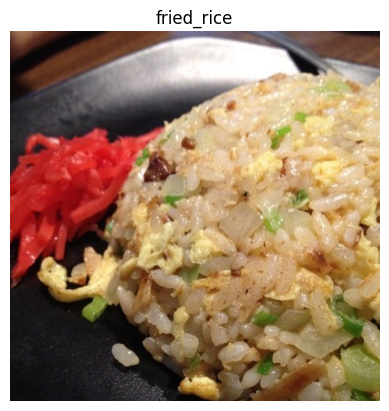

In [30]:
import helper_functions as hf
import random

img = hf.view_random_image(target_dir=train_dir,target_class=random.choice(class_names))

## 2. Configuración de Callbacks

Callbacks son funciones que se pueden pasar a un modelo de TensorFlow durante el entrenamiento para realizar una acción en un punto específico del entrenamiento. Algunos de los callbacks más comunes son:

- `tf.keras.callbacks.ModelCheckpoint` - Guarda el modelo en un intervalo específico.
- `tf.keras.callbacks.EarlyStopping` - Detiene el entrenamiento cuando una métrica deja de mejorar.
- `tf.keras.callbacks.TensorBoard` - Guarda los registros de entrenamiento para visualizarlos en TensorBoard.

In [24]:
# Create TensorBoard callback (functionized)
import datetime
import tensorflow as tf
def create_tensorboard_callback(dir_name, experiment_name):
    """
    Creates a TensorBoard callback instace to store TensorBoard logs.
    Saves logs with the file name: dir_name/experiment_name/current_datetime/
    Inputs:
        dir_name (str): Directory name to save TensorBoard log files.
        experiment_name (str): Experiment name.
    Returns:
        TensorBoard callback.
    """
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

## 3. Crear un modelo utilizando TensorFlow Hub

[TensorFlow Hub](https://www.tensorflow.org/hub) es una biblioteca y plataforma para la reutilización de módulos de aprendizaje profundo.

Es posible acceder a los modelos de TensorFlow Hub en https://tfhub.dev. 

:key: **Nota:** Para identificar los modelos que presentan mejor desempeño, se puede utilizar la pagina https://paperwithcode.com. 

- https://paperswithcode.com/task/image-classification

Buscando dentro de la pagina, se puede encontrar el modelo **EfficientNet** que es un modelo de **extracción de características** (feature-vector) de transfer learning que se puede usar para resolver problemas de clasificación de imágenes.

- **EfficientNet-B0**: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
- **ResNet50V2**: https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

> :key: **Nota:** Existen diferentes tipos de transfer learning, como es, feature extraction y fine-tuning.

1. **Transfer Learning**: Es cuando se toma un modelo preentrenado y se aplica a una nueva tarea sin cambios. 
    * **Ejemplo**: Si se utiliza un modelo preentrenado con el dataset imagenet que contiene 1000 clases diferentes. Esto significa que si se pasa una sola imagen, el modelo producirá 1000 probabilidades de que la imagen pertenezca a una de las 1000 clases. 
        * Sin embargo, no es útil si sólo quiere clasificar un pequeño subconjunto de clases (como 10 tipos diferentes de comida). Los modelos con "/classification" en su nombre en TensorFlow Hub proporcionan este tipo de funcionalidad.

2. **Feature extraction**: Es cuando se toma un modelo preentrenado y se reutiliza la parte de extracción de características (feature extraction) y se ajustan para que se adapten a los datos de nuestro problema.

    * **Ejemplo**: supongamos que el modelo preentrenado que estamos utilizando tiene 236 capas diferentes (EfficientNetB0 tiene 236 capas), pero la capa superior produce 1.000 clases porque se preentrenó en ImageNet. Para ajustar esto a su propio problema, podría eliminar la capa densa original y sustituirla por la suya propia, pero con el número correcto de clases de salida. **Lo importante aquí es que sólo se pueden entrenar las capas superiores, el resto permanece congelado.**
        * De este modo, todos los patrones subyacentes permanecen en el resto de las capas y puedes utilizarlos para tu propio problema. Este tipo de aprendizaje por transferencia es muy útil cuando tus datos son similares a los datos con los que se ha preentrenado un modelo.

3. **Fine tuning**: Es cuando se toma un modelo preentrenado y se reentrena en los datos de nuestro problema.

    * Esto suele implicar entrenar algunas, muchas o todas las capas del modelo preentrenado. Esto resulta útil cuando se dispone de un gran conjunto de datos (por ejemplo, más de 100 imágenes por clase) en el que los datos son ligeramente diferentes de los datos con los que se entrenó el modelo original.

> :eye: Un flujo de trabajo habitual es "congelar" todos los patrones aprendidos en las capas inferiores de un modelo preentrenado para que no se puedan entrenar. Y luego entrenar las 2-3 capas superiores para que el modelo preentrenado pueda ajustar sus salidas a sus datos personalizados (**extracción de características**). 
> Una vez entrenadas las dos o tres capas superiores, puede "descongelar" gradualmente cada vez más capas y ejecutar el proceso de entrenamiento con sus propios datos para afinar (**Fine Tuning**) aún más el modelo preentrenado.


<img src="https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-different-kinds-of-transfer-learning.png" width="700"/>

In [11]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [12]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# EfficientNetB0 feature vector (version 2)
#efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/2"

In [13]:
IMAGE_SHAPE+(3,) # Definida previamente como hiperparámetro

(224, 224, 3)

In [14]:
# Crear una función para crear un modelo a partir de una URL de TF Hub
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
    Args:
        model_url (str): A TensorFlow Hub feature extraction URL.
        num_classes (int): Number of output neurons in the output layer,
            should be equal to number of target classes, default 10.
    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor
        layer and Dense output layer with num_classes output neurons.
    """
    # Descargar el modelo y guardar en una variable (como un modelo Keras)
    feature_extractor_layer = hub.KerasLayer(model_url,
                                            trainable=False, # freeze the already learned patterns
                                            name='feature_extraction_layer',
                                            input_shape=IMAGE_SHAPE+(3,)) # input shape = imagenet shape
    
    # Crear un modelo secuencial
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])

    return model

### 3.1 Crear un modelo Resnet a partir de la URL de TF Hub 


<img src="https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-resnet-feature-extractor.png" width="700"/>


In [17]:
train_data_10_percent.num_classes

10

In [16]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)


In [19]:
# Compilar el modelo
resnet_model.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

In [25]:
# Entrenar el modelo
resnet_history = resnet_model.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                        experiment_name='resnet50v2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20221230-133901
Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20221230-133901
Epoch 1/5
24/24 [==============================] - 59s 2s/step - loss: 1.8784 - accuracy: 0.3613 - val_loss: 1.1562 - val_accuracy: 0.6428
Epoch 2/5
24/24 [==============================] - 29s 1s/step - loss: 0.8651 - accuracy: 0.7440 - val_loss: 0.8353 - val_accuracy: 0.7364
Epoch 3/5
24/24 [==============================] - 31s 1s/step - loss: 0.6030 - accuracy: 0.8400 - val_loss: 0.7357 - val_accuracy: 0.7632
Epoch 4/5
24/24 [==============================] - 29s 1s/step - loss: 0.4597 - accuracy: 0.8893 - val_loss: 0.6902 - val_accuracy: 0.7780
Epoch 5/5
24/24 [==============================] - 28s 1s/step - loss: 0.3761 - accuracy: 0.9120 - val_loss: 0.6768 - val_accuracy: 0.7828


El resultado del entrenamiento del modelo utilizando transfer learning y el modelo ResNet50V2, supera substancialmente el resultado del modelo creado desde cero, y el entrenamiento se realizó solamente utilizando 10% de los datos de entrenamiento.

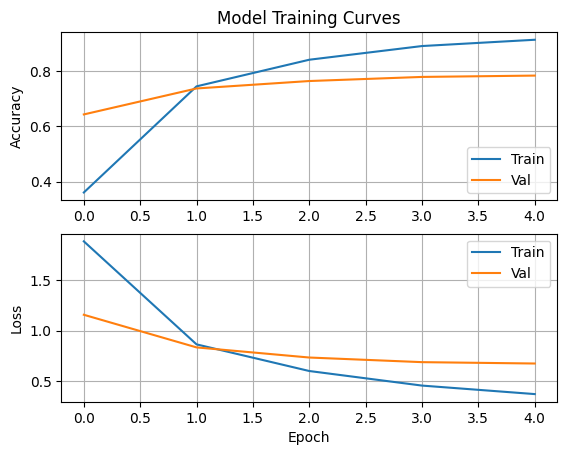

In [35]:
# Graficar las curvas de entrenamiento y validación utilizando la función plot_training_curves() del archivo helper_functions.py
hf.plot_training_curves(resnet_history)

### 3.2 Crear un modelo EfficientNet a partir de la URL de TF Hub

[EfficientNet: Improving Accuracy and Efficiency through AutoML and Model Scaling](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html)

<img src="https://1.bp.blogspot.com/-DjZT_TLYZok/XO3BYqpxCJI/AAAAAAAAEKM/BvV53klXaTUuQHCkOXZZGywRMdU9v9T_wCLcBGAs/s640/image2.png" width="700"/>

**Comparativa del desempeño de diferentes modelos con el dataset ImageNet.**

<img src="https://1.bp.blogspot.com/-oNSfIOzO8ko/XO3BtHnUx0I/AAAAAAAAEKk/rJ2tHovGkzsyZnCbwVad-Q3ZBnwQmCFsgCEwYBhgL/s640/image3.png" width="500"/>

In [42]:
# Crear un modelo con EfficientNetB0
efficientnet_model = create_model(efficientnet_url,
                            num_classes=train_data_10_percent.num_classes)

# Compilar el modelo
efficientnet_model.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

In [43]:
# Entrenar el modelo
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                            epochs=5,
                                            steps_per_epoch=len(train_data_10_percent),
                                            validation_data=test_data,
                                            validation_steps=len(test_data),
                                            callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                    experiment_name='efficientnetb0')])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20221230-144006
Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20221230-144006
Epoch 1/5
24/24 [==============================] - 41s 1s/step - loss: 1.8452 - accuracy: 0.4173 - val_loss: 1.3033 - val_accuracy: 0.7172
Epoch 2/5
24/24 [==============================] - 30s 1s/step - loss: 1.0729 - accuracy: 0.7613 - val_loss: 0.8694 - val_accuracy: 0.8208
Epoch 3/5
24/24 [==============================] - 28s 1s/step - loss: 0.7633 - accuracy: 0.8387 - val_loss: 0.6966 - val_accuracy: 0.8436
Epoch 4/5
24/24 [==============================] - 28s 1s/step - loss: 0.6124 - accuracy: 0.8573 - val_loss: 0.6111 - val_accuracy: 0.8528
Epoch 5/5
24/24 [==============================] - 30s 1s/step - loss: 0.5145 - accuracy: 0.8827 - val_loss: 0.5550 - val_accuracy: 0.8644


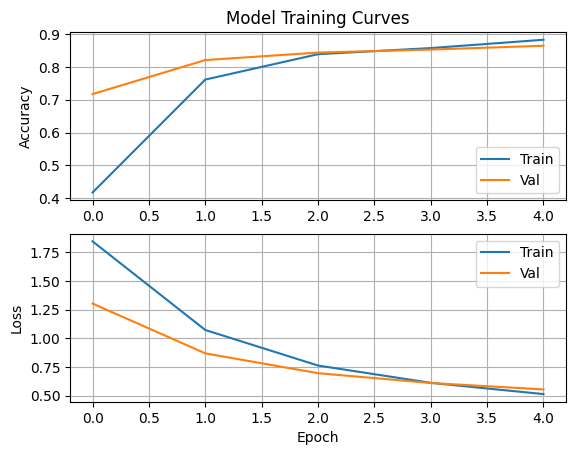

In [44]:
# Graficar las curvas de entrenamiento y validación
hf.plot_training_curves(efficientnet_history)

Comparando el número de parametros entre los modelos EfficientNet y ResNet50V2, se puede observar que el modelo EfficientNet tiene un número de parametros mucho menor que el modelo ResNet50V2, lo que significa que el modelo EfficientNet es mucho más ligero y más rápido de entrenar.

In [45]:
# La capa de extracción de características ha sido congelada, por lo tanto estos pesos no se actualizarán durante el entrenamiento
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [46]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


## 4. Comparando los resultados usando TensorBoard

**TensorBoard** es una herramienta de visualización de TensorFlow que nos permite visualizar y comparar los resultados de nuestros experimentos de machine learning.

> :key: **Nota:** Cuando se utiliza TensorBoard, los resultados se publican en una página web publica. Por lo tanto, si desea mantener sus resultados privados, debe ejecutar TensorBoard en su propia máquina.

> :eye: **Nota**: En caso de utilizar vscode, se debe instalar la extensión de TensorBoard para poder visualizar los resultados. y para poder visualizar los resultados en el navegador, se debe ejecutar los siguientes comandos:


1. Seleccionar el interprete de python adecuado: Command Palette -> Python Select Interpreter
2. Iniciar Tensorboard: command palette (ctrl+ shif + p) -> Python: Launch TensorBoard (Esperar a que se abra una ventana)
3. Seleccionar la carpeta donde se encuentran los archivos de registro de TensorBoard. Por defecto, se utilizará la carpeta actual abierta en el explorador de archivos de vs code.
4. Abrir una nueva pestaña en el navegador con la dirección http://localhost:6006/ donde se visualizarán los resultados.

In [4]:
# Cargar los registros de TensorBoard - Colab
"""
!tensorboard dev upload --logdir ./tensorflow_hub/ \
    --name "EfficientNetB0 vs. ResNet50V2" \
    --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
    --one_shot
"""

'\n!tensorboard dev upload --logdir ./tensorflow_hub/     --name "EfficientNetB0 vs. ResNet50V2"     --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images"     --one_shot\n'